# Analyse the SECOM dataset

Source: https://archive.ics.uci.edu/ml/datasets/SECOM

## Import libraries

In [172]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, recall_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier
import sys
sys.path.insert(0, '../modules/')
from secom_analysis import plot_confusion_matrix
from plotly.offline import iplot, init_notebook_mode
import plotly.graph_objs as go

init_notebook_mode(connected=True)

## Load data

In [2]:
DATA_DIR = '../data/'

### Loading features.

In [3]:
features_cols = ['f_'+str(feature_index) for feature_index in range(1, 591)]

In [4]:
data_df = pd.read_table(os.path.join(DATA_DIR, 'secom.data'), sep=' ', names=features_cols)

data_df.head()

,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,f_9,f_10,...,f_581,f_582,f_583,f_584,f_585,f_586,f_587,f_588,f_589,f_590
0,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,0.0162,...,NaN,NaN,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN
1,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,-0.0005,...,0.0060,208.2045,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045
2,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,0.0041,...,0.0148,82.8602,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602
3,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,1.4882,-0.0124,...,0.0044,73.8432,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432
4,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,1.5031,-0.0031,...,NaN,NaN,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432


### Loading labels and timestamps.

In [5]:
labels_df = pd.read_table(os.path.join(DATA_DIR, 'secom_labels.data'), sep=' ', names=['label', 'timestamp'])
labels_df.loc[labels_df['label']==-1,'label']=0

labels_df.head()

,label,timestamp
0,0,19/07/2008 11:55:00
1,0,19/07/2008 12:32:00
2,1,19/07/2008 13:17:00
3,0,19/07/2008 14:43:00
4,0,19/07/2008 15:22:00


In [6]:
data_df.shape, labels_df.shape

((1567, 590), (1567, 2))

In [7]:
labels_df.groupby('label').count()

,timestamp
label,
0,1463
1,104


### Joining features and labels data

In [8]:
data_df = data_df.join(labels_df, how='inner')

data_df.head()

,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,f_9,f_10,...,f_583,f_584,f_585,f_586,f_587,f_588,f_589,f_590,label,timestamp
0,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,0.0162,...,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN,0,19/07/2008 11:55:00
1,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,-0.0005,...,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045,0,19/07/2008 12:32:00
2,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,0.0041,...,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602,1,19/07/2008 13:17:00
3,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,1.4882,-0.0124,...,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432,0,19/07/2008 14:43:00
4,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,1.5031,-0.0031,...,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432,0,19/07/2008 15:22:00


In [9]:
data_df.shape

(1567, 592)

## Explore data

### Substitute null values with column mean

In [10]:
data_df_clean = data_df.fillna(data_df.mean())

In [11]:
data_df_clean.head()

,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,f_9,f_10,...,f_583,f_584,f_585,f_586,f_587,f_588,f_589,f_590,label,timestamp
0,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,0.0162,...,0.5005,0.0118,0.0035,2.3630,0.021458,0.016475,0.005283,99.670066,0,19/07/2008 11:55:00
1,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,-0.0005,...,0.5019,0.0223,0.0055,4.4447,0.009600,0.020100,0.006000,208.204500,0,19/07/2008 12:32:00
2,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,0.0041,...,0.4958,0.0157,0.0039,3.1745,0.058400,0.048400,0.014800,82.860200,1,19/07/2008 13:17:00
3,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,1.4882,-0.0124,...,0.4990,0.0103,0.0025,2.0544,0.020200,0.014900,0.004400,73.843200,0,19/07/2008 14:43:00
4,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,1.5031,-0.0031,...,0.4800,0.4766,0.1045,99.3032,0.020200,0.014900,0.004400,73.843200,0,19/07/2008 15:22:00


In [12]:
data_df_clean.describe()

,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,f_9,f_10,...,f_582,f_583,f_584,f_585,f_586,f_587,f_588,f_589,f_590,label
count,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.0,1567.000000,1567.000000,1567.000000,1567.000000,...,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000
mean,3014.452896,2495.850231,2200.547318,1396.376627,4.197013,100.0,101.112908,0.121822,1.462862,-0.000841,...,97.934373,0.500096,0.015318,0.003847,3.067826,0.021458,0.016475,0.005283,99.670066,0.066369
std,73.480613,80.227793,29.380932,439.712852,56.103066,0.0,6.209271,0.008936,0.073849,0.015107,...,54.936224,0.003403,0.017174,0.003719,3.576891,0.012354,0.008805,0.002866,93.861936,0.249005
min,2743.240000,2158.750000,2060.660000,0.000000,0.681500,100.0,82.131100,0.000000,1.191000,-0.053400,...,0.000000,0.477800,0.006000,0.001700,1.197500,-0.016900,0.003200,0.001000,0.000000,0.000000
25%,2966.665000,2452.885000,2181.099950,1083.885800,1.017700,100.0,97.937800,0.121100,1.411250,-0.010800,...,91.549650,0.497900,0.011600,0.003100,2.306500,0.013450,0.010600,0.003300,44.368600,0.000000
50%,3011.840000,2498.910000,2200.955600,1287.353800,1.317100,100.0,101.492200,0.122400,1.461600,-0.001300,...,97.934373,0.500200,0.013800,0.003600,2.757700,0.020500,0.014800,0.004600,72.023000,0.000000
75%,3056.540000,2538.745000,2218.055500,1590.169900,1.529600,100.0,104.530000,0.123800,1.516850,0.008400,...,97.934373,0.502350,0.016500,0.004100,3.294950,0.027600,0.020300,0.006400,114.749700,0.000000
max,3356.350000,2846.440000,2315.266700,3715.041700,1114.536600,100.0,129.252200,0.128600,1.656400,0.074900,...,737.304800,0.509800,0.476600,0.104500,99.303200,0.102800,0.079900,0.028600,737.304800,1.000000


### Find the columns with only one value

In [13]:
n_values_df = (pd.DataFrame(pd.Series({col: len(data_df_clean[col].value_counts()) for col in features_cols}))
               .reset_index()
               .rename({'index':'feature', 0:'value_counts'}, axis=1))

In [14]:
n_values_df.head(20)

,feature,value_counts
0,f_1,1521
1,f_2,1505
2,f_3,508
3,f_4,519
4,f_5,504
5,f_6,1
6,f_7,511
7,f_8,90
8,f_9,1209
9,f_10,569


The columns containing the same value for all the samples cannot be predictive of anything, therefore we drop them.

In [15]:
cols_to_drop = [n_values_df.iloc[i]['feature']
                for i in range(len(n_values_df))
                if n_values_df.iloc[i]['value_counts']==1]

cols_to_drop.append('timestamp')

In [16]:
print(f"Number of columns to drop: {len(cols_to_drop)}")

Number of columns to drop: 117


In [17]:
data_df_clean = data_df_clean.drop(cols_to_drop, axis=1)

## Train a random forest on the data

One class is much smaller than the other, which sets a baseline for the accuracy of the model used.

Train a random forest on the training data and perform 5-fold cross validation.

In [144]:
X = data_df_clean.drop(['label'], axis=1)
Y = data_df_clean['label']

In [153]:
rfc = RandomForestClassifier(class_weight={0: len(Y)-Y.sum(), 1:Y.sum()})

scores = cross_val_score(rfc, X, Y, cv=5)

scores.mean().round(4), scores.std().round(4)

(0.8827, 0.0661)

Perform a grid search on the number of trees in the forest.

In [154]:
param_grid = {'n_estimators': [10, 50, 100, 200, 500]}

gs = GridSearchCV(rfc, param_grid=param_grid, cv=5, verbose=1, return_train_score=False, scoring='recall')

In [155]:
gs.fit(X, Y)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:  2.7min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight={0: 1463, 1: 104},
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [10, 50, 100, 200, 500]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
       scoring='recall', verbose=1)

In [156]:
cv_results_df = pd.DataFrame(gs.cv_results_)

cv_results_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.381112,0.034890,0.002648,0.000062,10,{'n_estimators': 10},0.285714,0.000000,0.0,0.095238,0.0,0.076276,0.111138,5
1,1.819222,0.142635,0.007564,0.000198,50,{'n_estimators': 50},0.571429,0.047619,0.0,0.047619,0.0,0.133558,0.220229,1
2,3.726087,0.165352,0.013214,0.000328,100,{'n_estimators': 100},0.476190,0.047619,0.0,0.095238,0.0,0.123986,0.179811,4
3,7.400234,0.522282,0.024733,0.000521,200,{'n_estimators': 200},0.523810,0.047619,0.0,0.095238,0.0,0.133528,0.198537,2
4,18.626695,1.180544,0.062445,0.002764,500,{'n_estimators': 500},0.523810,0.047619,0.0,0.095238,0.0,0.133528,0.198537,2


Plot the results.

In [160]:
trace = go.Bar(
    x=cv_results_df['param_n_estimators'],
    y=cv_results_df['mean_test_score'],
    error_y=dict(
        type='data',
        array=cv_results_df['std_test_score'],
        visible=True
    ),
    name='mean recall'
)

data = [trace]

layout = go.Layout(
    yaxis = dict(
#         range=[0.91, 0.94],
        title='mean_recall'
    ),
    xaxis = dict(
        title='n_estimators'
    )
)

fig = go.Figure(data=data, layout=layout)

iplot(fig)

Let's have a look at a model with the best values for the parameters, using cross validation.

In [198]:
rfc_optimal = gs.best_estimator_

In [199]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

In [201]:
rfc_optimal.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, class_weight={0: 1463, 1: 104},
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=50, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [202]:
test_baseline_accuracy = 1.0-Y_test.sum()/len(Y_test)

print(f"Positives/negatives ratio in the test set: {Y_test.sum()/len(Y_test)}")
print(f"Baseline accuracy on test set: {test_baseline_accuracy}")
print(f"Model accuracy on test set: {accuracy_score(Y_test, rfc_optimal.predict(X_test))}")
print(f"Model recall on test set: {recall_score(Y_test, rfc_optimal.predict(X_test))}")

Positives/negatives ratio in the test set: 0.07643312101910828
Baseline accuracy on test set: 0.9235668789808917
Model accuracy on test set: 0.9140127388535032
Model recall on test set: 0.041666666666666664


In [204]:
fpr, tpr, thresholds = roc_curve(Y_test, rfc_optimal.predict(X_test))

trace = go.Scatter(
    x=fpr,
    y=tpr
)

data = [trace]

layout = go.Layout(
    xaxis = dict(
        title='FPR'
    ),
    yaxis = dict(
        title='TPR'
    ),
    title='ROC curve (random forest)'
)

fig = go.Figure(data=data, layout=layout)

iplot(fig)

Normalized confusion matrix
[[0.9862069  0.0137931 ]
 [0.95833333 0.04166667]]


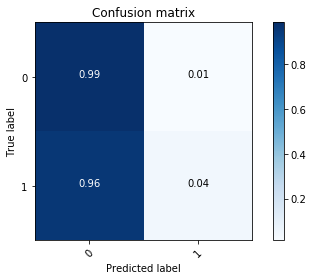

In [205]:
cm = confusion_matrix(Y_test, rfc_optimal.predict(X_test))

plot_confusion_matrix(cm, normalize=True, classes=[0,1])

## Manually specify class weights

In [191]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

print(f"Size of training dataset: {X_train.shape[0]}")
print(f"Number of positive training samples: {Y_train.sum()}")
print(f"Number of negative training samples: {len(Y_train)-Y_train.sum()}")

Size of training dataset: 1253
Number of positive training samples: 85
Number of negative training samples: 1168


In [192]:
class_weight = {0: len(Y_train)-Y_train.sum(), 1: Y_train.sum()}

rfc_weights = RandomForestClassifier(
    n_estimators=100,
    class_weight=class_weight
)

In [193]:
rfc_weights.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, class_weight={0: 1168, 1: 85},
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [194]:
test_baseline_accuracy = 1.0-Y_test.sum()/len(Y_test)

print(f"Positives/negatives ratio in the test set: {Y_test.sum()/len(Y_test)}")
print(f"Baseline accuracy on test set: {test_baseline_accuracy}")
print(f"Model accuracy on test set: {accuracy_score(Y_test, rfc_weights.predict(X_test))}")
print(f"Model recall on test set: {recall_score(Y_test, rfc_weights.predict(X_test))}")

Positives/negatives ratio in the test set: 0.06050955414012739
Baseline accuracy on test set: 0.9394904458598726
Model accuracy on test set: 0.9299363057324841
Model recall on test set: 0.15789473684210525


In [195]:
fpr, tpr, thresholds = roc_curve(Y_test, rfc_weights.predict(X_test))

trace = go.Scatter(
    x=fpr,
    y=tpr
)

data = [trace]

layout = go.Layout(
    xaxis = dict(
        title='FPR'
    ),
    yaxis = dict(
        title='TPR'
    ),
    title='ROC curve (random forest with manually specified class weights)'
)

fig = go.Figure(data=data, layout=layout)

iplot(fig)

Normalized confusion matrix
[[0.97966102 0.02033898]
 [0.84210526 0.15789474]]


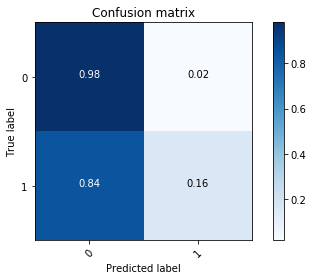

In [197]:
cm = confusion_matrix(Y_test, rfc_weights.predict(X_test))

plot_confusion_matrix(cm, normalize=True, classes=[0,1])

## Oversample the minority class

Let's proceed naively and oversample (or "upsample") the minority class by just duplicating the samples until they reach a 1:1 ratio with the majority class.

__Class ratio:__ reaching a 1:1 ratio between classes is not mandatory. Other ratios are possible and it's a matter of experimenting.

__When to oversample:__ oversampling the whole dataset, before splittin it into training and test sets, is a mistake, as copies of the same sample can then end up both in the training and test set when we do cross-validation, causing a leak of information between the two datsets. The right way to oversample is to __first__ splitting the data into training and test set and __then__ oversample the minority class __in the training set only__.

In [104]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

In [105]:
print(f"Size of training dataset: {X_train.shape[0]}")
print(f"Number of positive training samples: {Y_train.sum()}")
print(f"Number of negative training samples: {len(Y_train)-Y_train.sum()}")

Size of training dataset: 1253
Number of positive training samples: 78
Number of negative training samples: 1175


In [106]:
data_train = X_train.copy()
data_train.loc[:, 'label'] = Y_train.copy()

In [107]:
data_train = (data_train[data_train['label']==0].
              append(
                  data_train[data_train['label']==1].sample(int(Y_train.shape[0]/Y_train.sum())*len(X_train[Y_train==1]), replace=True)
              ))
data_train = data_train.sample(len(data_train)).reset_index().drop('index', axis=1)


data_train.shape

(2423, 475)

In [108]:
print(f"Size of oversampled training dataset: {data_train.shape[0]}")
print(f"Number of positive training samples after oversampling: {data_train['label'].sum()}")
print(f"Number of positive training samples after oversampling: {data_train[data_train['label']==0].shape[0]}")

Size of oversampled training dataset: 2423
Number of positive training samples after oversampling: 1248
Number of positive training samples after oversampling: 1175


In [109]:
rfc_optimal.fit(data_train.drop('label', axis=1), data_train['label'])

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [110]:
test_baseline_accuracy = 1.0-Y_test.sum()/len(Y_test)

print(f"Positives/negatives ratio in the test set: {Y_test.sum()/len(Y_test)}")
print(f"Baseline accuracy on test set: {test_baseline_accuracy}")
print(f"Model accuracy on test set: {accuracy_score(Y_test, rfc_optimal.predict(X_test))}")
print(f"Model recall on test set: {recall_score(Y_test, rfc_optimal.predict(X_test))}")

Positives/negatives ratio in the test set: 0.08280254777070063
Baseline accuracy on test set: 0.9171974522292994
Model accuracy on test set: 0.9171974522292994
Model recall on test set: 0.0


## Undersample the majority class

In [208]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

print(f"Size of training dataset: {X_train.shape[0]}")
print(f"Number of positive training samples: {Y_train.sum()}")
print(f"Number of negative training samples: {len(Y_train)-Y_train.sum()}")

Size of training dataset: 1253
Number of positive training samples: 79
Number of negative training samples: 1174


In [230]:
data_to_upload = X_test.copy()
data_to_upload['label']=Y_test.copy()

In [235]:
data_to_upload.to_csv("../data/test_upload.csv", index=False)

In [229]:
data_to_upload.to_csv("../data/upload_training.csv", index=False)

In [209]:
downsampled_negatives = X_train[Y_train==0].sample(len(X_train[Y_train==1])).reset_index().drop('index', axis=1)
downsampled_negatives.loc[:,'label']=0

positives = X_train[Y_train==1].reset_index().drop('index', axis=1)
positives.loc[:, 'label']=1

downsampled_training_data = downsampled_negatives.append(positives)

In [210]:
rfc_downsample = RandomForestClassifier(n_estimators=100, class_weight='balanced')

In [211]:
rfc_downsample.fit(downsampled_training_data.drop('label', axis=1), downsampled_training_data['label'])

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [212]:
test_baseline_accuracy = 1.0-Y_test.sum()/len(Y_test)

print(f"Positives/negatives ratio in the test set: {Y_test.sum()/len(Y_test)}")
print(f"Baseline accuracy on test set: {test_baseline_accuracy}")
print(f"Model accuracy on test set: {accuracy_score(Y_test, rfc_downsample.predict(X_test))}")
print(f"Model recall on test set: {recall_score(Y_test, rfc_downsample.predict(X_test))}")

Positives/negatives ratio in the test set: 0.07961783439490445
Baseline accuracy on test set: 0.9203821656050956
Model accuracy on test set: 0.60828025477707
Model recall on test set: 0.72


Plot the ROC curve and the confusion matrix.

In [215]:
fpr, tpr, thresholds = roc_curve(Y_test, rfc_downsample.predict(X_test))

trace = go.Scatter(
    x=fpr,
    y=tpr
)

data = [trace]

layout = go.Layout(
    xaxis = dict(
        title='FPR'
    ),
    yaxis = dict(
        title='TPR'
    ),
    title='ROC curve (random forest with undersampling)'
)

fig = go.Figure(data=data, layout=layout)

iplot(fig)

Normalized confusion matrix
[[0.59861592 0.40138408]
 [0.28       0.72      ]]


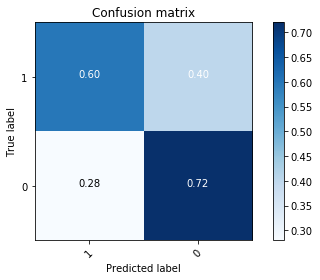

In [216]:
cm = confusion_matrix(Y_test, rfc_downsample.predict(X_test))

plot_confusion_matrix(cm, normalize=True, classes=[1,0])

## Alternative approach: try to see if something is visible using dimensional reduction

In [95]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold.t_sne import TSNE

In [88]:
X_scaled = StandardScaler().fit_transform(X)

In [89]:
pca = PCA(n_components=2)

In [90]:
X_red = pca.fit_transform(X_scaled)

In [92]:
trace1 = go.Scatter(
    x=X_red[np.argwhere(Y.values==0)[:,0]][:,0],
    y=X_red[np.argwhere(Y.values==0)[:,0]][:,1],
    mode='markers',
    name='class 0'
)

trace2 = go.Scatter(
    x=X_red[np.argwhere(Y.values==1)[:,0]][:,0],
    y=X_red[np.argwhere(Y.values==1)[:,0]][:,1],
    mode='markers',
    name='class 1'
)

layout = go.Layout(
    xaxis=dict(
        title='pca_1'
    ),
    yaxis=dict(
        title='pca_2'
    )
)

fig = go.Figure(data=[trace1, trace2], layout=layout)

iplot(fig)

In [96]:
X_red_2 = TSNE().fit_transform(X_scaled)

In [98]:
trace1 = go.Scatter(
    x=X_red_2[np.argwhere(Y.values==0)[:,0]][:,0],
    y=X_red_2[np.argwhere(Y.values==0)[:,0]][:,1],
    mode='markers',
    name='class 0'
)

trace2 = go.Scatter(
    x=X_red_2[np.argwhere(Y.values==1)[:,0]][:,0],
    y=X_red_2[np.argwhere(Y.values==1)[:,0]][:,1],
    mode='markers',
    name='class 1'
)

layout = go.Layout(
    xaxis=dict(
        title='T-SNE_1'
    ),
    yaxis=dict(
        title='T-SNE_2'
    )
)

fig = go.Figure(data=[trace1, trace2], layout=layout)

iplot(fig)